# Grad Cam

In [120]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


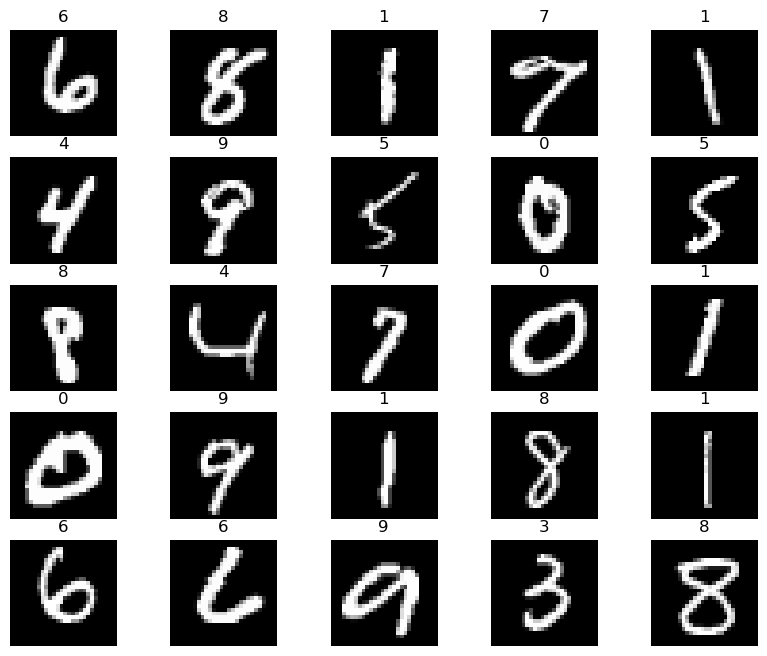

In [121]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [122]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x20e4c846c70>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x20e496bd310>}

In [143]:
import torch.nn as nn
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2,                  
            ),                              
            nn.ReLU(),                      
            #nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            #nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 16* 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
cnn = CNN()
print(cnn)
#summary(cnn, input_size=(1, 28, 28), device="cuda")

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=25088, out_features=10, bias=True)
)


In [144]:
from torch import optim

loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [600/600], Loss: 0.0673
Epoch [2/10], Step [600/600], Loss: 0.0226
Epoch [3/10], Step [600/600], Loss: 0.1196
Epoch [4/10], Step [600/600], Loss: 0.0487
Epoch [5/10], Step [600/600], Loss: 0.0462
Epoch [6/10], Step [600/600], Loss: 0.0649
Epoch [7/10], Step [600/600], Loss: 0.0531
Epoch [8/10], Step [600/600], Loss: 0.0105
Epoch [9/10], Step [600/600], Loss: 0.0100
Epoch [10/10], Step [600/600], Loss: 0.0189


https://fleuret.org/dlc/materials/dlc-slides-9-3-visualizing-in-input.pdf

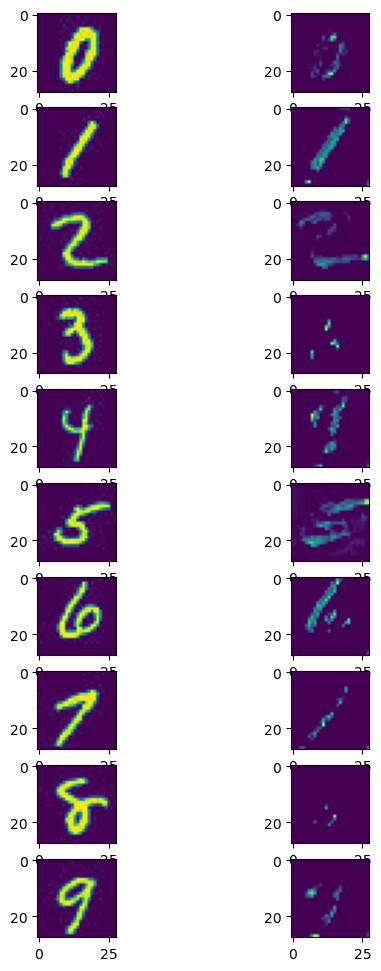

In [247]:
import torchvision
import PIL

def hook_store_A(module, input, output):
    module.A = output[0]

def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]

layer = cnn.conv2[0]
layer.register_forward_hook(hook_store_A)
layer.register_backward_hook(hook_store_dydA)

to_tensor = torchvision.transforms.ToTensor()

classes = range(0, 10)
orig_imgs = []
gradcam_imgs = []
for c in classes:
    orig_img = f"data/{c}.jpg"
    orig_imgs.append(orig_img)
    input = to_tensor(PIL.Image.open(orig_img)).unsqueeze(0)
    # Compute netowrks output:
    output = cnn(input)[0]
    output[0, c].backward()
    #print(layer.dydA.shape)
    alpha = layer.dydA.mean((2, 3), keepdim = True)
    L = torch.relu((alpha * layer.A).sum(1, keepdim = True))
    L = L / L.max()
    L = F.interpolate(L, size = (input.size(2), input.size(3)), mode = 'bilinear', align_corners = False)
    l = L.view(L.size(2), L.size(3)).detach().numpy()
    gradcam_imgs.append(l)

fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(6, 12))
idx = 0
for orig_img_path, gradcam_img in zip(orig_imgs, gradcam_imgs):
    orig_img = PIL.Image.open(orig_img_path)
    axs[idx, 0].imshow(orig_img)
    axs[idx, 1].imshow(gradcam_img, vmin=0, vmax=1)
    idx += 1
plt.show()

0, does provide some explainability though the marked regions are not only specific to a zero
1, provides good explainability  
2, provides good explainability   
3, provides bad explainability  
4, the activation does actually look a lot like a 9  
5, provides good explainability    
6, provides good explainability    
7, provides bad explainability, could as well be a 1  
8, activation is hardly visible. It is a strange sample of an 8 though
9, the activation does provide some explainability, though other numbers like 7 or 4 could also have the same shape 